In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/model_2020_05_23-16_43_01.h5'

TEST_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 100.0
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/model_2020_05_23-16_43_01.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [4]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [101]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [6]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = batch_size
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Classification Generator 

In [60]:
class RandomBalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen=ImageDataGenerator(), batch_size=1):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape   
        
        self.datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        
    def __len__(self):
        return self.steps_per_epoch   
    
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


class DeterministicBalancedGenerator(Sequence):
    def __init__(self, balanced_gen):
        self.x_gen = []
        self.y_gen = []
        self.steps_per_epoch = balanced_gen.steps_per_epoch
        
        for i in range(balanced_gen.steps_per_epoch):
            x, y = balanced_gen.__getitem__(None)
            self.x_gen.append(x)
            self.y_gen.append(y)
        
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        return self.x_gen[idx], self.y_gen[idx]

# Triplet Loss 

In [8]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [34]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer(name='encoded').output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = Dropout(rate=0.5)(base_model.get_layer(output_name).output)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [53]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
#     mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
#     mlflow.log_param("seed", RANDOM_SEED)
#     mlflow.log_param("alpha", ALPHA)
#     mlflow.log_param("batch_size", BATCH_SIZE)
#     mlflow.log_param("file_model", FILE_MODEL)
#     mlflow.set_tag("requirement", name)
#     mlflow.set_tag("type", "embeddings")
#     mlflow.keras.autolog()
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=1,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)
    mlflow.end_run()


def train_classification_model(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
#         ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
#     mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
#     mlflow.log_param("seed", RANDOM_SEED)
#     mlflow.log_param("batch_size", BATCH_SIZE)
#     mlflow.log_param("file_model", FILE_MODEL)
#     mlflow.set_tag("requirement", name)
#     mlflow.set_tag("type", "classification")
#     mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=train_gen.steps_per_epoch,
        epochs=1,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [98]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared
    
def run_classification_training(model_shared, train_data, valid_data, train_gen, valid_gen, name):
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    
    valid_bal = RandomBalancedDataGenerator(x_valid, y_valid, valid_gen, BATCH_SIZE)
    train_gen_bal = RandomBalancedDataGenerator(x_train, y_train, train_gen, BATCH_SIZE)
    valid_gen_bal = DeterministicBalancedGenerator(valid_bal)
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, train_gen_bal, valid_gen_bal, name)

    x_gen = valid_gen.flow(x_valid, batch_size=len(y_valid), shuffle=False).next()
    y_pred = model_classification.predict(x_gen).flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_valid, y_pred)
    
    return model_classification, file_model

In [13]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

900 of 900
846 of 846
(1396, 160, 160, 3) float32
(1396,) int32
(350, 160, 160, 3) float32
(350,) int32


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
100/100 [==============================] - 38s 376ms/step - loss: 93.6626 - val_loss: 79.0715


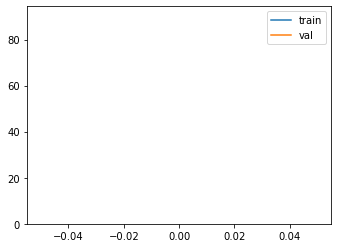

In [14]:
train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Epoch 1/1
45/45 [==============================] - 8s 167ms/step - loss: 0.7364 - accuracy: 0.5854 - precision: 0.6256 - recall: 0.4282 - f1: 0.4986 - specificity: 0.7470 - negative_predictive_value: 0.5686 - matthews_correlation_coefficient: 0.1840 - equal_error_rate: 0.4273 - val_loss: 0.6104 - val_accuracy: 0.6392 - val_precision: 0.9318 - val_recall: 0.2898 - val_f1: 0.4341 - val_specificity: 0.9788 - val_negative_predictive_value: 0.5804 - val_matthews_correlation_coefficient: 0.3642 - val_equal_error_rate: 0.4004
(350, 1) (350,)

   Final Accuracy:  62.57%
  Final Precision:  94.55%
     Final Recall:  28.89%
  Final F-measure:  44.26%
Final Specificity:  98.24%
        Final NPV:  56.61%
        Final MCC:  37.25%

[[167   3]
 [128  52]]
              precision    recall  f1-score   support

           0       0.57      0.98      0.72       170
           1       0.95      0.29      0.44       180

    accuracy                           0.63       350
   macro avg       0.76    

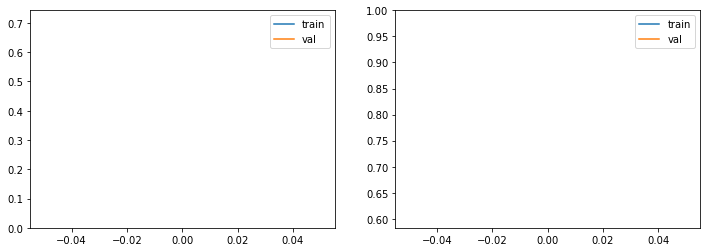

In [99]:
model_clf, file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

In [ ]:
random_gen = RandomTripletGenerator(x_pos_valid, x_neg_valid, 128, random_seed=42)
det_gen = DeterministicTripletGenerator(random_gen, steps_per_epoch=100)

In [ ]:
(anc, pos, neg), _ = det_gen.__getitem__(10)
print(anc.shape, pos.shape, neg.shape)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow((anc.squeeze()).astype(np.uint8)[:, :, ::-1])

plt.subplot(1, 3, 2)
plt.imshow((pos.squeeze()).astype(np.uint8)[:, :, ::-1])

plt.subplot(1, 3, 3)
plt.imshow((neg.squeeze()).astype(np.uint8)[:, :, ::-1])

In [ ]:
random_gen = RandomBalancedDataGenerator(x_valid, y_valid)
det_gen = DeterministicBalancedGenerator(random_gen)

In [ ]:
x, y = det_gen.__getitem__(20)
print(x.shape, y.shape)

print(y)
plt.figure(figsize=(20, 6))
plt.imshow((x.squeeze()).astype(np.uint8)[:, :, ::-1])